# Proj-H402 : Deep Neural Network Image Processing
## Brain tumor classification

-------
###  Imports and definition of functions

In [7]:
import numpy as np
import random


from skimage.io import imread,imsave,imshow

import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential


from tensorflow.keras.layers import InputLayer, Flatten, Dense , Dropout, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import visualkeras

import os

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import itertools

In [8]:
def plot_graphs(history):
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.history['accuracy']))

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
    plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [9]:
from collections import defaultdict

color_map = defaultdict(dict)
color_map[InputLayer]['fill'] = 'cornflowerblue'
color_map[Dropout]['fill'] = 'darkcyan'
color_map[Conv2D]['fill'] = 'skyblue'
color_map[MaxPooling2D]['fill'] = 'blue'
color_map[BatchNormalization]['fill'] = 'lightblue' 
color_map[Flatten]['fill'] = 'royalblue'
color_map[Dense]['fill'] = 'darkblue'

-------
## Data preprocessing
The original dataset comes from https://github.com/sartajbhuvaji/brain-tumor-classification-dataset  

The folder contains MRI's data. The images are already split into Training and Testing folders.  
Each folder has more four subfolders. These folders have MRI's of respective tumor classes.

In [4]:
print('There are: \n')

for dirname, _, _ in os.walk('Training/'):
    if dirname != 'Training/':
        print('     ',len(os.listdir(dirname)), 'images in', dirname)
        
for dirname, _, _ in os.walk('Testing/'):
    if dirname != 'Testing/':
        print('     ', len(os.listdir(dirname)), 'images in', dirname)

There are: 

      395 images in Training/no_tumor
      823 images in Training/meningioma_tumor
      826 images in Training/glioma_tumor
      827 images in Training/pituitary_tumor
      105 images in Testing/no_tumor
      115 images in Testing/meningioma_tumor
      100 images in Testing/glioma_tumor
      74 images in Testing/pituitary_tumor


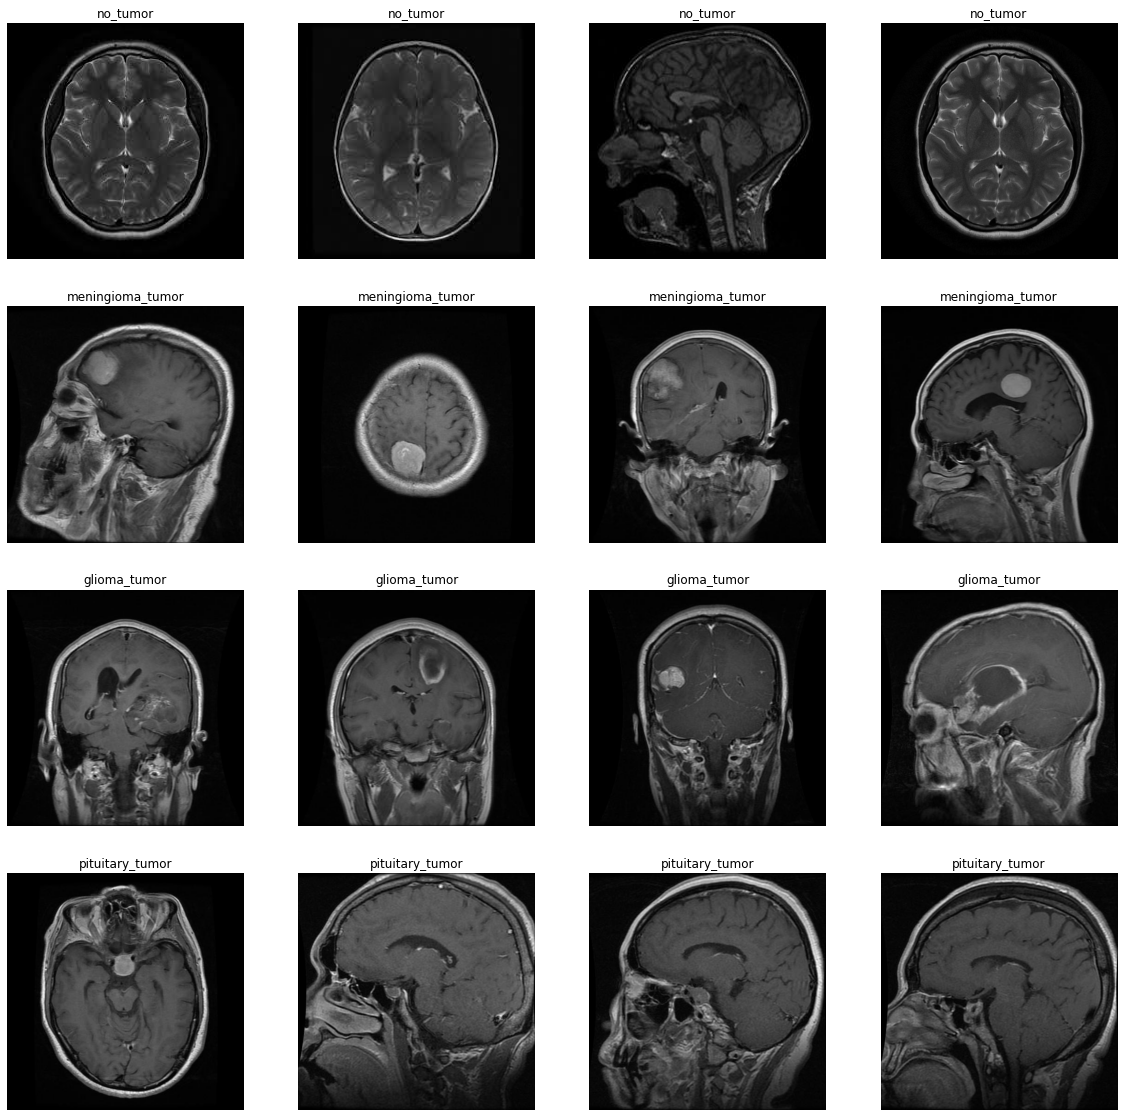

In [5]:
no_tumor = os.listdir('Training/no_tumor')
meningioma_tumor = os.listdir('Training/meningioma_tumor')
glioma_tumor = os.listdir('Training/glioma_tumor')
pituitary_tumor = os.listdir('Training/pituitary_tumor')

plt.figure(figsize=(20,20))
posplot = 1
for i in [random.randint(0,len(no_tumor)) for j in range(28)]:
    if posplot <= 4:
        plt.subplot(4,4,posplot)
        plt.title('no_tumor')
        plt.imshow(imread('Training/no_tumor/'+ no_tumor[i]))
        plt.axis('off')
        
    elif posplot > 4 and posplot <= 8:
        plt.subplot(4,4,posplot)
        plt.title('meningioma_tumor')
        plt.imshow(imread('Training/meningioma_tumor/'+ meningioma_tumor[i]))
        plt.axis('off')
    elif posplot > 8 and posplot <= 12:
        plt.subplot(4,4,posplot)
        plt.title('glioma_tumor')
        plt.imshow(imread('Training/glioma_tumor/'+ glioma_tumor[i]))
        plt.axis('off')
    elif posplot > 12 and posplot <= 16:
        plt.subplot(4,4,posplot)
        plt.title('pituitary_tumor')
        plt.imshow(imread('Training/pituitary_tumor/'+ pituitary_tumor[i]))
        plt.axis('off')
    
    posplot +=1

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 181,
                                   validation_split = 0.138)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
training_dataset = train_datagen.flow_from_directory('Training_cropped/',
                                                     target_size=(128,128),
                                                     color_mode="grayscale",
                                                     subset="training",
                                                     class_mode='categorical',
                                                     shuffle = True)

validation_dataset = train_datagen.flow_from_directory('Training_cropped/',
                                                       target_size=(128,128),
                                                       color_mode="grayscale",
                                                       subset="validation",
                                                       class_mode='categorical', 
                                                       shuffle = True)

testing_dataset = test_datagen.flow_from_directory('Testing_cropped/',
                                                   target_size=(128,128),
                                                   color_mode="grayscale",
                                                   class_mode='categorical',
                                                   shuffle = False)

Found 2476 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


This corresponds to 76% training, 12% validation and 12% testing

In [6]:
target_names = ['glioma tumor', 'meningioma tumor', 'no tumor', 'pituitary tumor']

## Homemade Model

In [7]:
classifier = Sequential()

classifier.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (128,128, 3), activation = "relu"))
classifier.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu"))
classifier.add(MaxPooling2D(pool_size = (6,6)))
classifier.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu"))
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = "relu"))
classifier.add(Dense(units = 4, activation = "softmax"))



classifier.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])



classifier.summary()

2022-05-16 15:56:32.171927: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1327232   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5

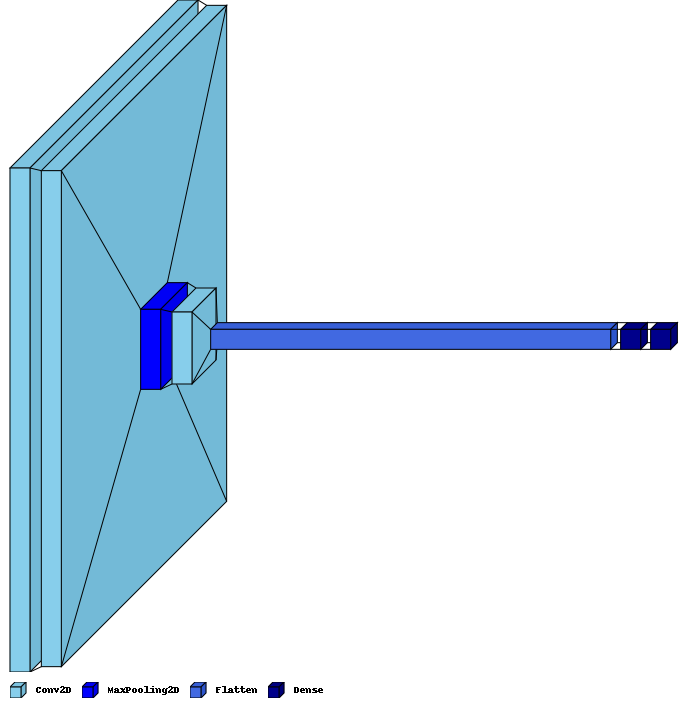

In [8]:
visualkeras.layered_view(classifier, legend=True, color_map=color_map)

## Fitting the model

2022-05-16 15:56:33.778802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
78/78 [==============================] - 80s 998ms/step - loss: 1.3344 - accuracy: 0.3223 - val_loss: 1.3303 - val_accuracy: 0.3325
Epoch 2/30
78/78 [==============================] - 96s 1s/step - loss: 1.0852 - accuracy: 0.5178 - val_loss: 1.1072 - val_accuracy: 0.5102
Epoch 3/30
78/78 [==============================] - 89s 1s/step - loss: 0.9730 - accuracy: 0.5905 - val_loss: 1.0797 - val_accuracy: 0.5939
Epoch 4/30
78/78 [==============================] - 86s 1s/step - loss: 0.8852 - accuracy: 0.6252 - val_loss: 1.0002 - val_accuracy: 0.6015
Epoch 5/30
78/78 [==============================] - 81s 1s/step - loss: 0.8139 - accuracy: 0.6632 - val_loss: 0.9220 - val_accuracy: 0.6371
Epoch 6/30
78/78 [==============================] - 77s 977ms/step - loss: 0.7293 - accuracy: 0.6995 - val_loss: 0.9159 - val_accuracy: 0.6294
Epoch 7/30
78/78 [==============================] - 73s 933ms/step - loss: 0.6931 - accuracy: 0.7153 - val_loss: 0.7707 - val_accuracy: 0.7081
Epoch 8/30


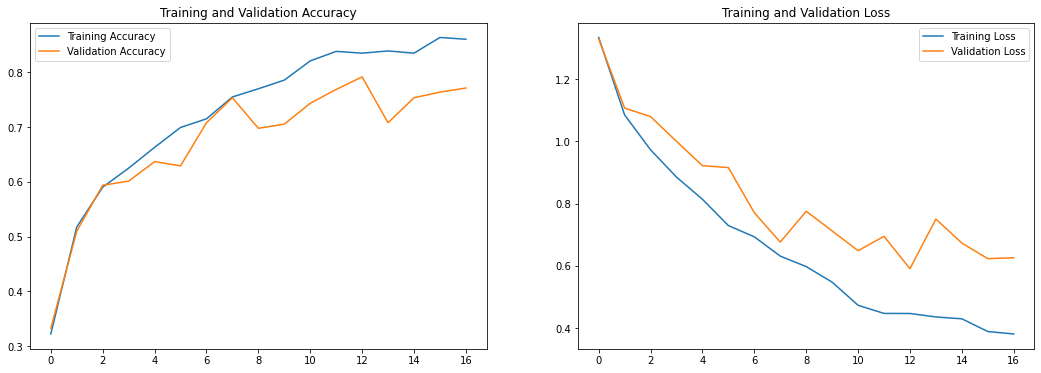

In [9]:
callbacks = [ EarlyStopping(patience = 4, 
                            monitor = "val_accuracy", 
                            restore_best_weights = True),
              ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, 
                                patience = 2, min_delta = 0.001, 
                                mode='auto',verbose=1) ]

history_classifier = classifier.fit(training_dataset,
                                    epochs = 30,
                                    validation_data = validation_dataset, 
                                    callbacks = callbacks)

plot_graphs(history_classifier)

## Evaluating the model

In [10]:
classifier.evaluate(testing_dataset, verbose=1)
predictions = classifier.predict(testing_dataset, verbose=1)

13/13 [==============================] - 3s 205ms/step


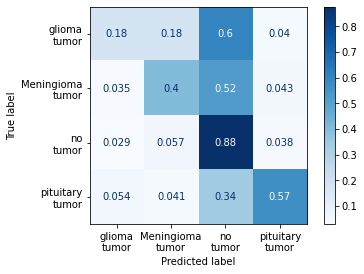

In [11]:
pred = np.argmax(predictions, axis=1)
ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred, 
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'], 
                                        cmap='Blues', normalize = 'true')

In [12]:
print(classification_report(testing_dataset.labels, pred, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.62      0.18      0.28       100
meningioma tumor       0.63      0.40      0.49       115
        no tumor       0.39      0.88      0.54       105
 pituitary tumor       0.76      0.57      0.65        74

        accuracy                           0.50       394
       macro avg       0.60      0.51      0.49       394
    weighted avg       0.59      0.50      0.48       394



------
## AIMS network
> Hassan Ali Khan,  Wu Jue,  Muhammad Mushtaq,  Muhammad Umer Mushtaq. Brain tumor classification in MRI image using convolutional neural network[J]. Mathematical Biosciences and Engineering, 2020, 17(5): 6203-6216. doi: 10.3934/mbe.2020328

In [13]:
AIMS_classifier = Sequential()

AIMS_classifier.add(Conv2D(filters = 16,kernel_size = (3, 3),input_shape = (128,128, 3),activation = "relu"))
AIMS_classifier.add(MaxPooling2D(pool_size = (2,2)))
AIMS_classifier.add(Conv2D(filters = 32,kernel_size = (3, 3),input_shape = (128,128, 3),activation = "relu"))
AIMS_classifier.add(Conv2D(filters = 32,kernel_size = (3, 3),input_shape = (128,128, 3),activation = "relu"))
AIMS_classifier.add(MaxPooling2D(pool_size = (2,2)))
AIMS_classifier.add(Conv2D(filters = 64,kernel_size = (3, 3),input_shape = (128,128, 3),activation = "relu"))
AIMS_classifier.add(Conv2D(filters = 64,kernel_size = (3, 3),input_shape = (128,128, 3),activation = "relu"))
AIMS_classifier.add(Conv2D(filters = 64,kernel_size = (3, 3),input_shape = (128,128, 3),activation = "relu"))
AIMS_classifier.add(MaxPooling2D(pool_size = (2,2)))
AIMS_classifier.add(Conv2D(filters = 128,kernel_size = (3, 3),input_shape = (128,128, 3),activation = "relu"))
AIMS_classifier.add(Conv2D(filters = 128,kernel_size = (3, 3),input_shape = (128,128, 3),activation = "relu"))
AIMS_classifier.add(MaxPooling2D(pool_size = (2,2)))
AIMS_classifier.add(Flatten())
AIMS_classifier.add(Dense(units = 256, activation = "relu"))
AIMS_classifier.add(Dense(units = 4, activation = "softmax"))

AIMS_classifier.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

AIMS_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 64)       

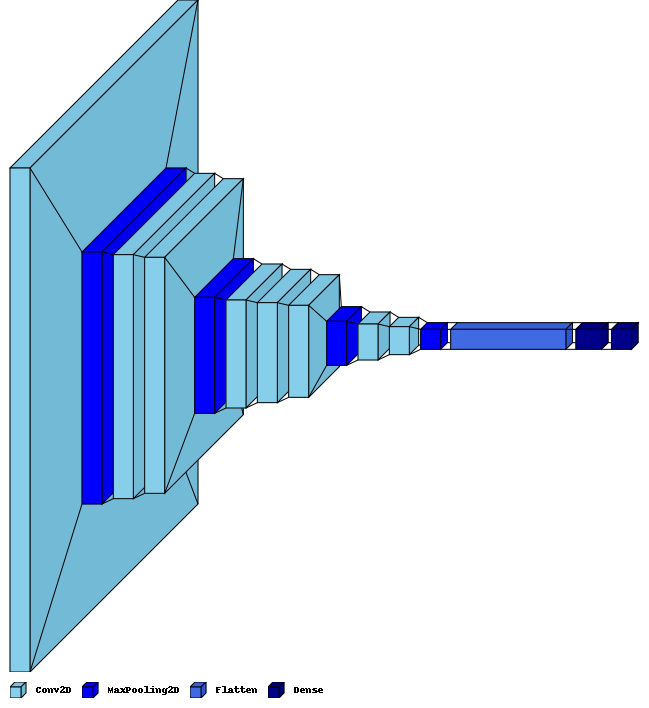

In [14]:
visualkeras.layered_view(AIMS_classifier, legend=True, color_map=color_map)

## Fitting the model

Epoch 1/30
78/78 [==============================] - 65s 826ms/step - loss: 1.3577 - accuracy: 0.3053 - val_loss: 1.3637 - val_accuracy: 0.2868
Epoch 2/30
78/78 [==============================] - 63s 810ms/step - loss: 1.2760 - accuracy: 0.3574 - val_loss: 1.2260 - val_accuracy: 0.4112
Epoch 3/30
78/78 [==============================] - 60s 769ms/step - loss: 1.1915 - accuracy: 0.4321 - val_loss: 1.2456 - val_accuracy: 0.4086
Epoch 4/30
78/78 [==============================] - 57s 729ms/step - loss: 1.1188 - accuracy: 0.4818 - val_loss: 1.3385 - val_accuracy: 0.4188
Epoch 5/30
78/78 [==============================] - 66s 848ms/step - loss: 1.1063 - accuracy: 0.4859 - val_loss: 1.2584 - val_accuracy: 0.4340
Epoch 6/30
78/78 [==============================] - 63s 804ms/step - loss: 1.0631 - accuracy: 0.5254 - val_loss: 1.1591 - val_accuracy: 0.4695
Epoch 7/30
78/78 [==============================] - 70s 891ms/step - loss: 0.9855 - accuracy: 0.5590 - val_loss: 1.2272 - val_accuracy: 0.4416

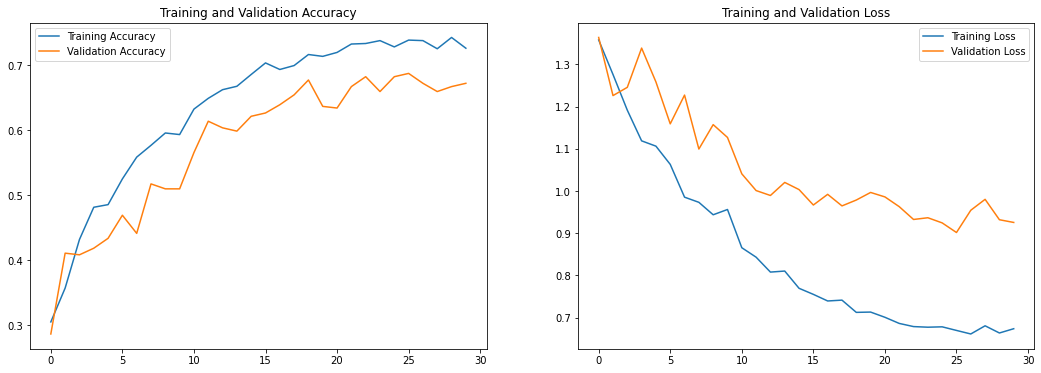

In [15]:
callbacks_AIMS = [ EarlyStopping(patience = 4, 
                            monitor = "val_accuracy", 
                            restore_best_weights = True),
                   ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, 
                                     patience = 2, min_delta = 0.001, 
                                     mode='auto',verbose=1) ]

history_AIMS_classifier = AIMS_classifier.fit(training_dataset, 
                                              epochs = 30, 
                                              validation_data = validation_dataset, 
                                              callbacks = callbacks_AIMS)

plot_graphs(history_AIMS_classifier)

In [17]:
AIMS_classifier.evaluate(testing_dataset, verbose=1)
AIMS_predictions = AIMS_classifier.predict(testing_dataset, verbose=1)

13/13 [==============================] - 3s 200ms/step


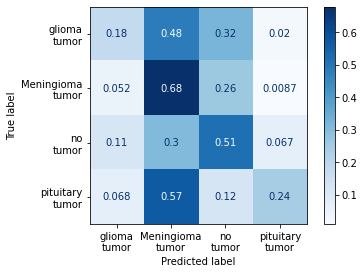

In [18]:
AIMS_pred = np.argmax(AIMS_predictions, axis=1)
ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, AIMS_pred, 
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'], 
                                        cmap='Blues', normalize = 'true')

In [19]:
print(classification_report(testing_dataset.labels, AIMS_pred, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.44      0.18      0.26       100
meningioma tumor       0.39      0.68      0.50       115
        no tumor       0.43      0.51      0.47       105
 pituitary tumor       0.64      0.24      0.35        74

        accuracy                           0.43       394
       macro avg       0.48      0.40      0.39       394
    weighted avg       0.46      0.43      0.40       394



## A third Model
Let's design a little more sophisticated model

In [11]:
inputs = tf.keras.Input(shape=(128, 128, 1))

x = BatchNormalization()(inputs)
x = Conv2D(filters = 16,kernel_size = (3, 3),activation = "relu", padding="same")(x)

x = BatchNormalization()(x)
x = Conv2D(filters = 16,kernel_size = (3, 3),activation = "relu", padding="same")(x)

x = tf.keras.layers.Add()([inputs, x])

x = MaxPooling2D(pool_size = (2,2))(x)



x = BatchNormalization()(x)
y = Conv2D(filters = 32,kernel_size = (3, 3),activation = "relu", padding="same")(x)

x = BatchNormalization()(y)
x = Conv2D(filters = 32,kernel_size = (3, 3),activation = "relu", padding="same")(x)

x = tf.keras.layers.Add()([y, x])

x = MaxPooling2D(pool_size = (2,2))(x)



x = BatchNormalization()(x)
y = Conv2D(filters = 64,kernel_size = (3, 3),activation = "relu", padding="same")(x)

x = BatchNormalization()(x)
x = Conv2D(filters = 64,kernel_size = (3, 3),activation = "relu", padding="same")(x)

x = tf.keras.layers.Add()([y, x])

x = MaxPooling2D(pool_size = (2,2))(x)

x = Flatten()(x)
x = Dense(units = 256, activation = "relu")(x)
out = Dense(units = 4, activation = "softmax")(x)

model3= tf.keras.Model(inputs=inputs, outputs=out)


model3.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 128, 128, 1)  4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 16) 160         batch_normalization_6[0][0]      
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 128, 128, 16) 64          conv2d_6[0][0]                   
____________________________________________________________________________________________

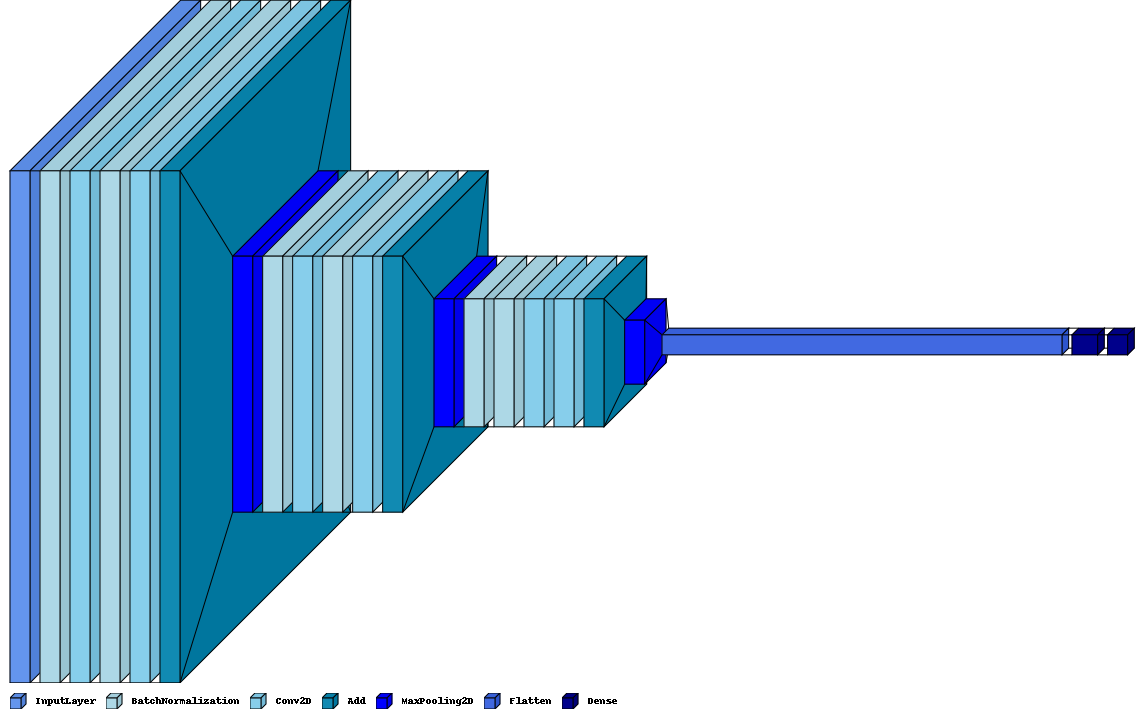

In [13]:
visualkeras.layered_view(model3, legend=True, color_map=color_map)

Epoch 1/30
78/78 [==============================] - 114s 1s/step - loss: 4.0523 - accuracy: 0.3825 - val_loss: 1.3760 - val_accuracy: 0.3503
Epoch 2/30
78/78 [==============================] - 92s 1s/step - loss: 1.0954 - accuracy: 0.5141 - val_loss: 1.4687 - val_accuracy: 0.3731
Epoch 3/30
78/78 [==============================] - 98s 1s/step - loss: 0.9910 - accuracy: 0.5852 - val_loss: 1.7559 - val_accuracy: 0.2970
Epoch 4/30
78/78 [==============================] - 92s 1s/step - loss: 0.9011 - accuracy: 0.6151 - val_loss: 1.1890 - val_accuracy: 0.3858
Epoch 5/30
78/78 [==============================] - 91s 1s/step - loss: 0.8231 - accuracy: 0.6579 - val_loss: 1.1102 - val_accuracy: 0.5431
Epoch 6/30
78/78 [==============================] - 92s 1s/step - loss: 0.8340 - accuracy: 0.6519 - val_loss: 0.9314 - val_accuracy: 0.5812
Epoch 7/30
78/78 [==============================] - 119s 2s/step - loss: 0.7528 - accuracy: 0.6955 - val_loss: 1.2001 - val_accuracy: 0.5914
Epoch 8/30
78/78 [

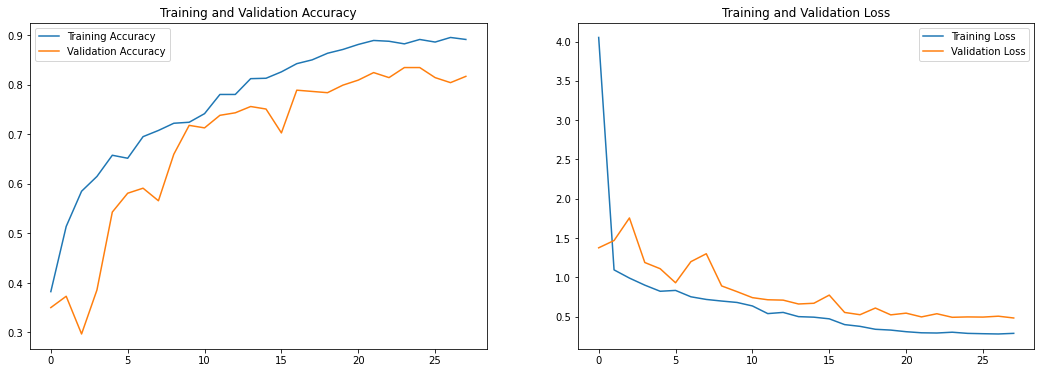

In [17]:
callbacks_model3 = [ EarlyStopping(patience = 4, 
                            monitor = "val_accuracy", 
                            restore_best_weights = True),
                   ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, 
                                     patience = 2, min_delta = 0.001, 
                                     mode='auto',verbose=1) ]

history_model3 = model3.fit(training_dataset, 
                            epochs = 30, 
                            validation_data = validation_dataset, 
                            callbacks = callbacks_model3)

plot_graphs(history_model3)

13/13 [==============================] - 4s 278ms/step


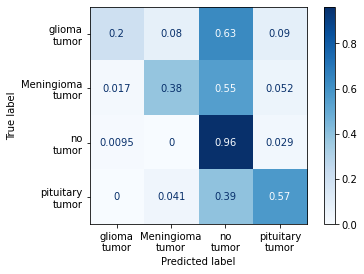

In [19]:
model3.evaluate(testing_dataset, verbose=1)
model3_predictions = model3.predict(testing_dataset, verbose=1)

model3_pred = np.argmax(model3_predictions, axis=1)
ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, model3_pred, 
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'], 
                                        cmap='Blues', normalize = 'true')

In [55]:
print(classification_report(testing_dataset.labels, model3_pred, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.87      0.20      0.33       100
meningioma tumor       0.80      0.38      0.52       115
        no tumor       0.39      0.96      0.56       105
 pituitary tumor       0.70      0.57      0.63        74

        accuracy                           0.53       394
       macro avg       0.69      0.53      0.51       394
    weighted avg       0.69      0.53      0.50       394



--------------
# Transfert learning

In [30]:
training_dataset = train_datagen.flow_from_directory('Training_cropped/',
                                                     target_size=(128,128),
                                                     color_mode="rgb",
                                                     subset="training",
                                                     class_mode='categorical',
                                                     shuffle = True)

validation_dataset = train_datagen.flow_from_directory('Training_cropped/',
                                                       target_size=(128,128),
                                                       color_mode="rgb",
                                                       subset="validation",
                                                       class_mode='categorical', 
                                                       shuffle = True)

testing_dataset = test_datagen.flow_from_directory('Testing_cropped/',
                                                   target_size=(128,128),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   shuffle = False)

Found 2476 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


--------
## VGG 16

In [31]:
from keras.applications.vgg16 import VGG16


vgg16_input = VGG16(include_top=False, 
                     weights = 'imagenet',
                     pooling = 'avg',
                     input_shape = (128,128, 3), 
                     classes = 4)

vgg16_input.trainable = False

vgg16_top = vgg16_input.output
vgg16_top = Dense(units = 1024, activation = "relu")(vgg16_top)
vgg16_top = BatchNormalization()(vgg16_top)
vgg16_top = Dropout(0.4)(vgg16_top)
out = Dense(units = 4, activation = "softmax")(vgg16_top)

my_vgg16 = Model(inputs = vgg16_input.input, outputs = out)

    
my_vgg16.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

my_vgg16.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

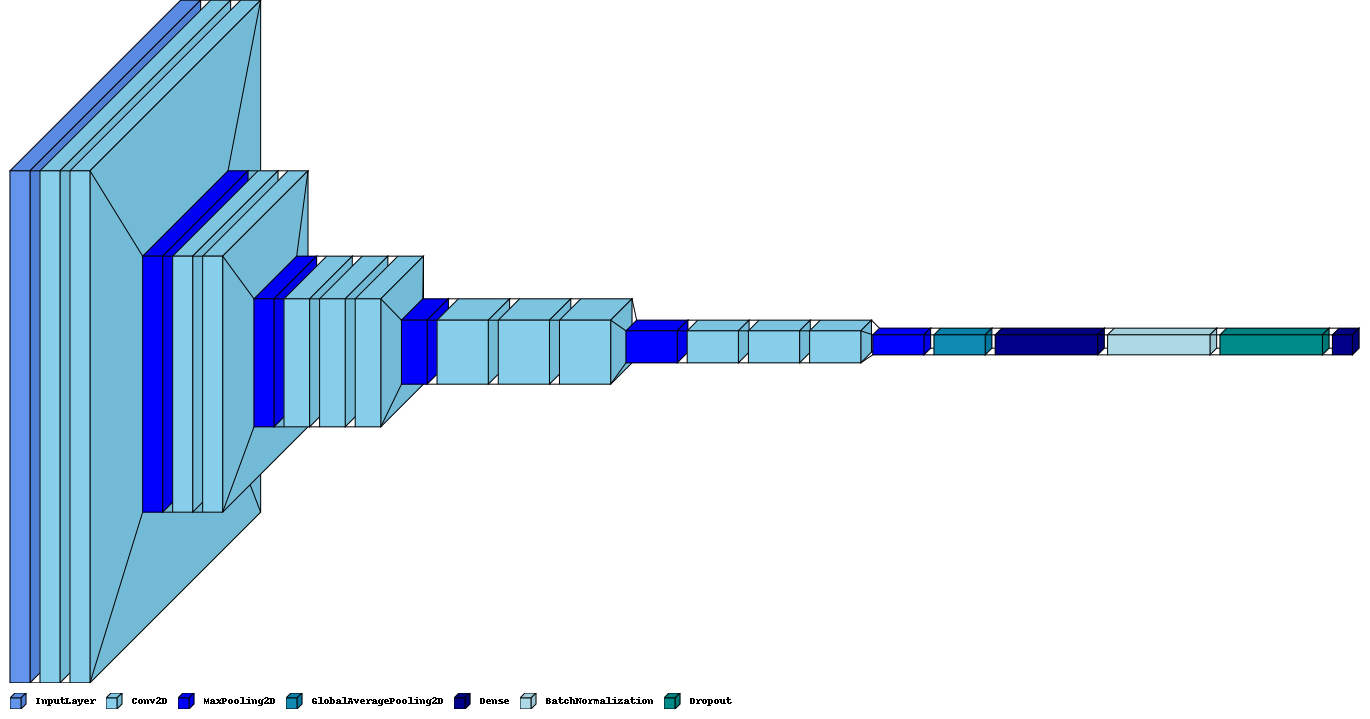

In [32]:
visualkeras.layered_view(my_vgg16, legend=False, color_map=color_map)

Epoch 1/30
78/78 [==============================] - 322s 4s/step - loss: 0.9747 - accuracy: 0.6535 - val_loss: 1.1464 - val_accuracy: 0.4746
Epoch 2/30
78/78 [==============================] - 286s 4s/step - loss: 0.7327 - accuracy: 0.7298 - val_loss: 1.0431 - val_accuracy: 0.4873
Epoch 3/30
78/78 [==============================] - 272s 3s/step - loss: 0.6863 - accuracy: 0.7363 - val_loss: 0.8962 - val_accuracy: 0.6320
Epoch 4/30
78/78 [==============================] - 271s 3s/step - loss: 0.6676 - accuracy: 0.7484 - val_loss: 1.3409 - val_accuracy: 0.3706
Epoch 5/30
78/78 [==============================] - 344s 4s/step - loss: 0.6284 - accuracy: 0.7520 - val_loss: 0.7404 - val_accuracy: 0.7107
Epoch 6/30
78/78 [==============================] - 311s 4s/step - loss: 0.6221 - accuracy: 0.7617 - val_loss: 0.8722 - val_accuracy: 0.6269
Epoch 7/30
78/78 [==============================] - 301s 4s/step - loss: 0.6127 - accuracy: 0.7557 - val_loss: 0.6754 - val_accuracy: 0.7310
Epoch 8/30
78

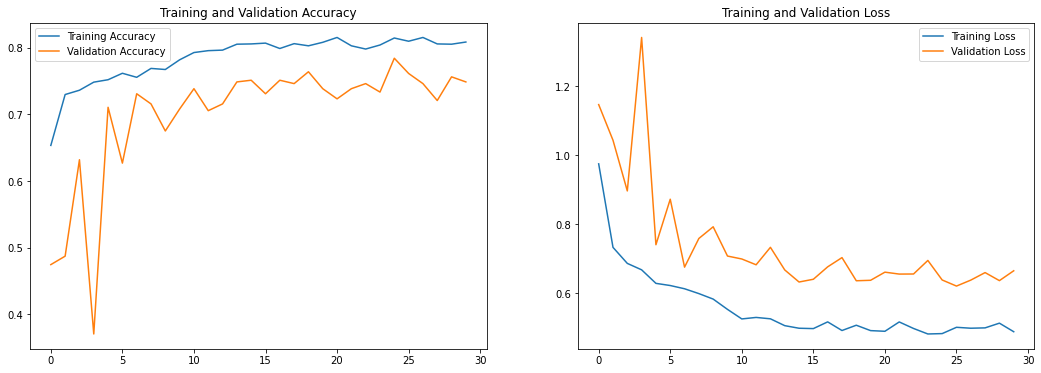

In [33]:
callbacks_vgg = [ EarlyStopping(patience = 10, 
                            monitor = "accuracy", 
                            restore_best_weights = True),
                 ReduceLROnPlateau(monitor = 'val_accuracy', 
                                   factor = 0.3, patience = 2, 
                                   min_delta = 0.001, 
                                   mode='auto',verbose=1) ]

history_my_vgg16 = my_vgg16.fit(training_dataset,
                                epochs = 30,
                                validation_data = validation_dataset,
                                callbacks = callbacks_vgg)

plot_graphs(history_my_vgg16)

13/13 [==============================] - 35s 3s/step


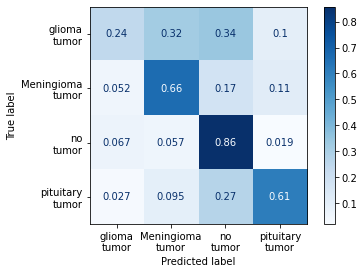

In [34]:
my_vgg16.evaluate(testing_dataset, verbose=1)
predictions_vgg = my_vgg16.predict(testing_dataset, verbose=1)
pred_vgg = np.argmax(predictions_vgg, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_vgg, 
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'], 
                                        cmap='Blues', normalize = 'true')

In [56]:
print(classification_report(testing_dataset.labels, pred_vgg, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.62      0.24      0.35       100
meningioma tumor       0.63      0.66      0.64       115
        no tumor       0.55      0.86      0.67       105
 pituitary tumor       0.64      0.61      0.62        74

        accuracy                           0.60       394
       macro avg       0.61      0.59      0.57       394
    weighted avg       0.61      0.60      0.57       394



--------
## RESnet

In [36]:
from tensorflow.keras.applications.resnet50 import ResNet50
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

ResNet50_input = ResNet50(include_top=False,
                    weights='imagenet',
                    pooling = 'avg',
                    input_shape=(128,128, 3),
                    classes = 4)

ResNet50_input.trainable = False

ResNet50_top = ResNet50_input.output
ResNet50_top = Dense(units = 1024, activation = "relu")(ResNet50_top)
#ResNet50_top = BatchNormalization()(ResNet50_top)
#ResNet50_top = Dropout(0.4)(ResNet50_top)
out = Dense(units = 4, activation = "softmax")(ResNet50_top)

my_ResNet50 = Model(inputs = ResNet50_input.input, outputs = out)

    
my_ResNet50.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

my_ResNet50.summary()

94781440/94765736 [==============================] - 14s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
__________________________

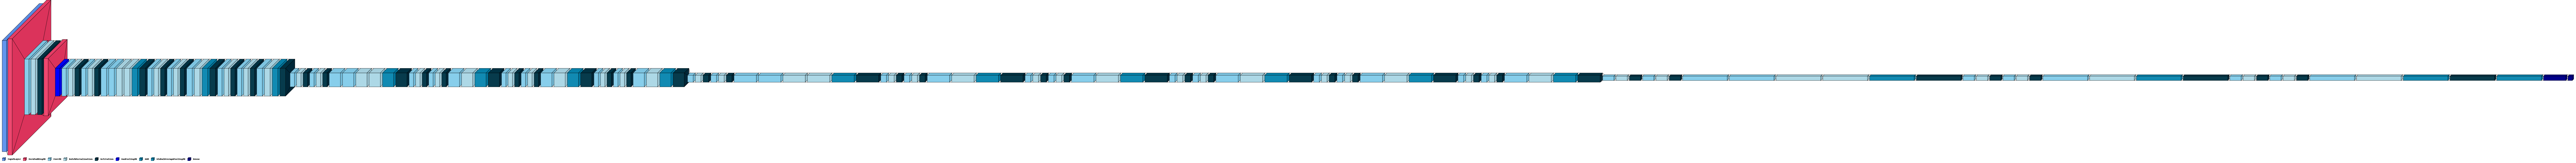

In [51]:
visualkeras.layered_view(my_ResNet50, legend=True, color_map=color_map)

Epoch 1/30
78/78 [==============================] - 134s 2s/step - loss: 1.3174 - accuracy: 0.3481 - val_loss: 1.4294 - val_accuracy: 0.3249
Epoch 2/30
78/78 [==============================] - 122s 2s/step - loss: 1.2554 - accuracy: 0.3962 - val_loss: 1.3113 - val_accuracy: 0.3274
Epoch 3/30
78/78 [==============================] - 125s 2s/step - loss: 1.2176 - accuracy: 0.4309 - val_loss: 1.3322 - val_accuracy: 0.3452
Epoch 4/30
78/78 [==============================] - 120s 2s/step - loss: 1.1901 - accuracy: 0.4491 - val_loss: 1.2963 - val_accuracy: 0.3198
Epoch 5/30
78/78 [==============================] - 119s 2s/step - loss: 1.1820 - accuracy: 0.4402 - val_loss: 1.3541 - val_accuracy: 0.3376

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/30
78/78 [==============================] - 120s 2s/step - loss: 1.1528 - accuracy: 0.4612 - val_loss: 1.2967 - val_accuracy: 0.3249
Epoch 7/30
78/78 [==============================] - 134s 2s/step - loss: 

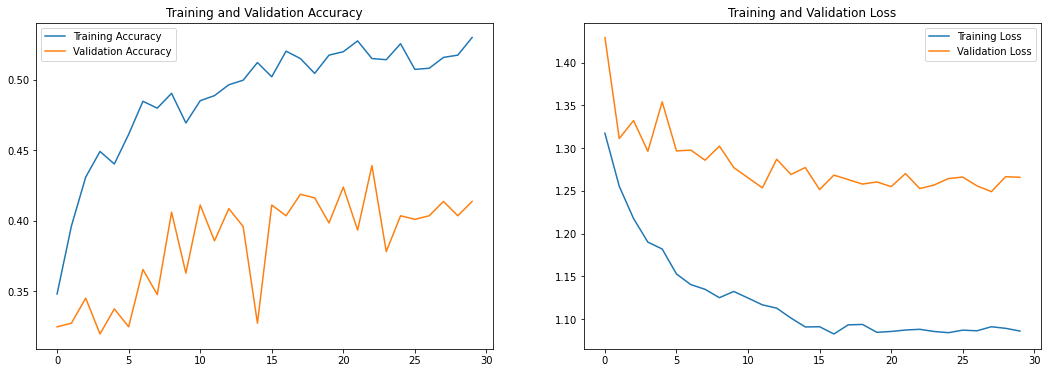

In [43]:
callbacks_RESnet = [ EarlyStopping(patience = 10, 
                            monitor = "accuracy", 
                            restore_best_weights = True),
                 ReduceLROnPlateau(monitor = 'val_accuracy', 
                                   factor = 0.3, patience = 2, 
                                   min_delta = 0.001, 
                                   mode='auto',verbose=1) ]

history_my_RESnet = my_ResNet50.fit(training_dataset,
                                epochs = 30,
                                validation_data = validation_dataset,
                                callbacks = callbacks_RESnet)

plot_graphs(history_my_RESnet)

13/13 [==============================] - 18s 1s/step


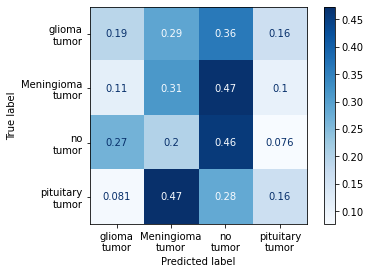

In [47]:
my_ResNet50.evaluate(testing_dataset, verbose=1)
predictions_ResNet = my_ResNet50.predict(testing_dataset, verbose=1)
pred_ResNet = np.argmax(predictions_ResNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_ResNet, 
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'], 
                                        cmap='Blues', normalize = 'true')

In [57]:
print(classification_report(testing_dataset.labels, pred_ResNet, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.29      0.19      0.23       100
meningioma tumor       0.30      0.31      0.31       115
        no tumor       0.30      0.46      0.36       105
 pituitary tumor       0.25      0.16      0.20        74

        accuracy                           0.29       394
       macro avg       0.28      0.28      0.27       394
    weighted avg       0.29      0.29      0.28       394



---------
## MobileNet

In [37]:
from tensorflow.keras.applications.mobilenet import MobileNet

MobileNet_input = MobileNet(include_top=False,
                            weights='imagenet',
                            pooling = 'avg',
                            input_shape=(128,128, 3),
                            classes = 4)

MobileNet_input.trainable = False

MobileNet_top = MobileNet_input.output
MobileNet_top = Dense(units = 1024, activation = "relu")(MobileNet_top)
out = Dense(units = 4, activation = "softmax")(MobileNet_top)

my_MobileNet = Model(inputs = MobileNet_input.input, outputs = out)

my_MobileNet.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

my_MobileNet.summary()

17235968/17225924 [==============================] - 2s 0us/step
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
____________________________________________________________

dense_15 (Dense)             (None, 4)                 4100      
Total params: 4,282,564
Trainable params: 1,053,700
Non-trainable params: 3,228,864
_________________________________________________________________


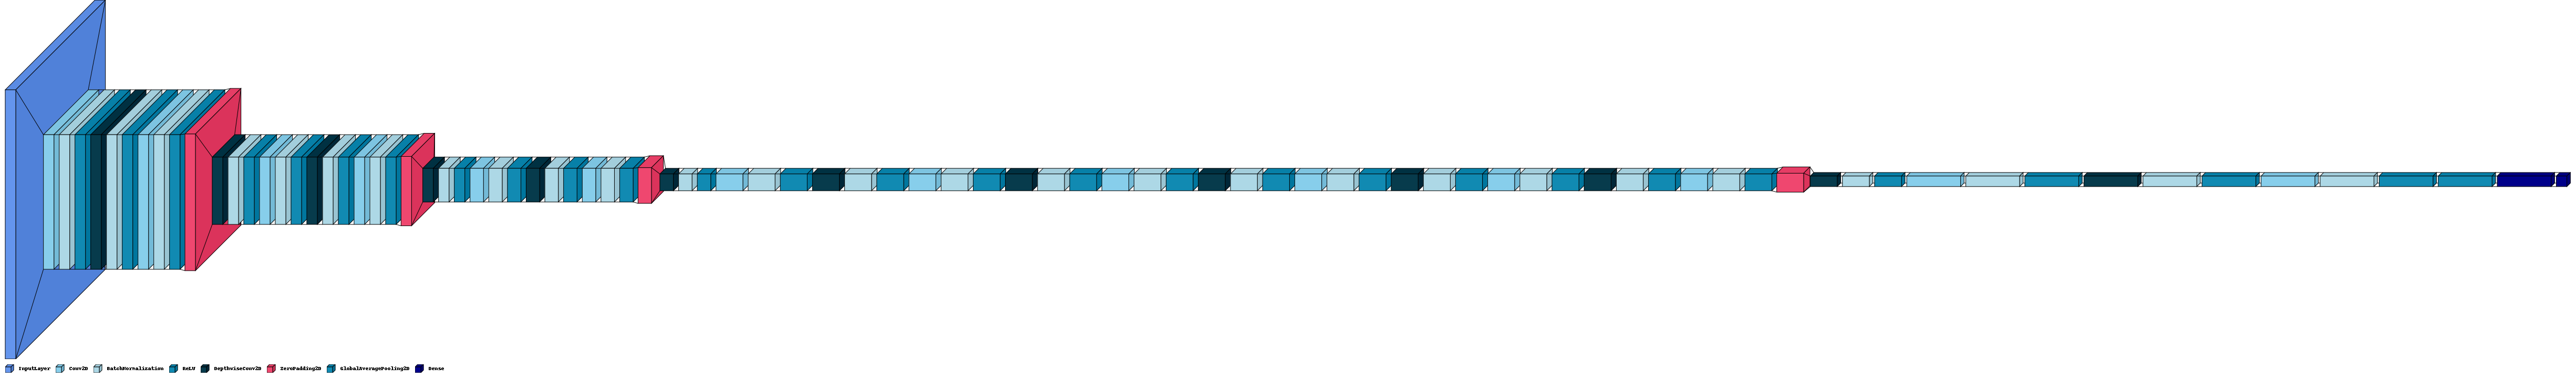

In [52]:
visualkeras.layered_view(my_MobileNet, legend=True, color_map=color_map)

Epoch 1/30
78/78 [==============================] - 46s 567ms/step - loss: 0.8820 - accuracy: 0.7217 - val_loss: 0.8541 - val_accuracy: 0.6802
Epoch 2/30
78/78 [==============================] - 44s 567ms/step - loss: 0.4379 - accuracy: 0.8340 - val_loss: 0.4916 - val_accuracy: 0.7919
Epoch 3/30
78/78 [==============================] - 43s 546ms/step - loss: 0.3857 - accuracy: 0.8526 - val_loss: 0.5443 - val_accuracy: 0.7944
Epoch 4/30
78/78 [==============================] - 39s 502ms/step - loss: 0.3603 - accuracy: 0.8566 - val_loss: 0.5572 - val_accuracy: 0.7919
Epoch 5/30
78/78 [==============================] - 40s 510ms/step - loss: 0.3267 - accuracy: 0.8760 - val_loss: 0.4222 - val_accuracy: 0.8376
Epoch 6/30
78/78 [==============================] - 40s 506ms/step - loss: 0.3005 - accuracy: 0.8817 - val_loss: 0.5026 - val_accuracy: 0.8122
Epoch 7/30
78/78 [==============================] - 39s 502ms/step - loss: 0.3198 - accuracy: 0.8744 - val_loss: 0.4397 - val_accuracy: 0.8376

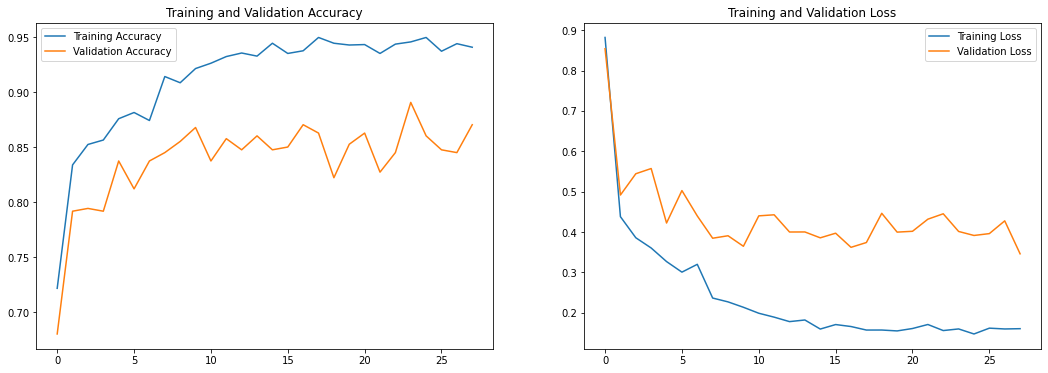

In [44]:
callbacks_MobileNet = [ EarlyStopping(patience = 10, 
                            monitor = "accuracy", 
                            restore_best_weights = True),
                 ReduceLROnPlateau(monitor = 'val_accuracy', 
                                   factor = 0.3, patience = 2, 
                                   min_delta = 0.001, 
                                   mode='auto',verbose=1) ]

history_my_MobileNet = my_MobileNet.fit(training_dataset,
                                epochs = 30,
                                validation_data = validation_dataset,
                                callbacks = callbacks_MobileNet)

plot_graphs(history_my_MobileNet)

13/13 [==============================] - 6s 416ms/step


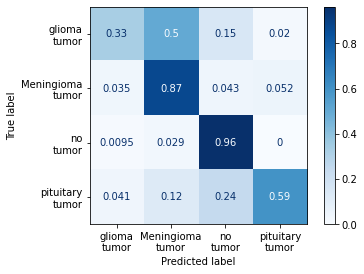

In [48]:
my_MobileNet.evaluate(testing_dataset, verbose=1)
predictions_MobileNet = my_MobileNet.predict(testing_dataset, verbose=1)
pred_MobileNet = np.argmax(predictions_MobileNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_MobileNet, 
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'], 
                                        cmap='Blues', normalize = 'true')

In [58]:
print(classification_report(testing_dataset.labels, pred_MobileNet, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.80      0.33      0.47       100
meningioma tumor       0.62      0.87      0.72       115
        no tumor       0.73      0.96      0.83       105
 pituitary tumor       0.85      0.59      0.70        74

        accuracy                           0.71       394
       macro avg       0.75      0.69      0.68       394
    weighted avg       0.74      0.71      0.68       394



---------
## DenseNet121

In [39]:
from tensorflow.keras.applications.densenet import DenseNet121

DenseNet_input = DenseNet121(include_top=False,
                             weights='imagenet',
                             pooling = 'avg',
                             input_shape=(128,128, 3),
                             classes = 4)

DenseNet_input.trainable = False

DenseNet_top = DenseNet_input.output
DenseNet_top = Dense(units = 1024, activation = "relu")(DenseNet_top)
out = Dense(units = 4, activation = "softmax")(DenseNet_top)

my_DenseNet = Model(inputs = DenseNet_input.input, outputs = out)

my_DenseNet.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

my_DenseNet.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

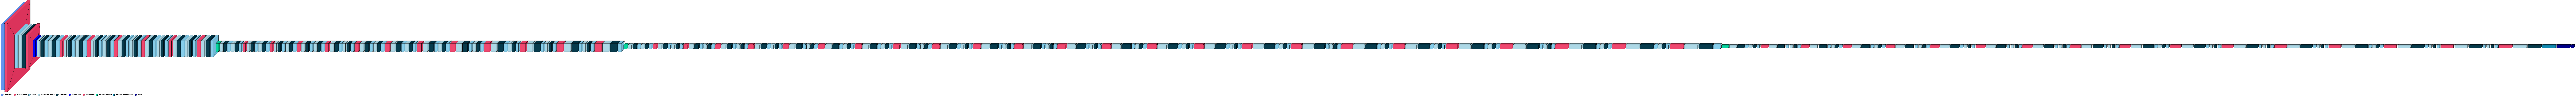

In [53]:
visualkeras.layered_view(my_DenseNet, legend=True, color_map=color_map)

Epoch 1/30
78/78 [==============================] - 131s 2s/step - loss: 1.0710 - accuracy: 0.6450 - val_loss: 0.7625 - val_accuracy: 0.6650
Epoch 2/30
78/78 [==============================] - 122s 2s/step - loss: 0.5573 - accuracy: 0.7795 - val_loss: 0.7280 - val_accuracy: 0.6980
Epoch 3/30
78/78 [==============================] - 121s 2s/step - loss: 0.4950 - accuracy: 0.8029 - val_loss: 0.7085 - val_accuracy: 0.7107
Epoch 4/30
78/78 [==============================] - 122s 2s/step - loss: 0.4618 - accuracy: 0.8275 - val_loss: 0.6204 - val_accuracy: 0.7766
Epoch 5/30
78/78 [==============================] - 122s 2s/step - loss: 0.4190 - accuracy: 0.8389 - val_loss: 0.7004 - val_accuracy: 0.7056
Epoch 6/30
78/78 [==============================] - 121s 2s/step - loss: 0.4185 - accuracy: 0.8514 - val_loss: 0.6305 - val_accuracy: 0.7411

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/30
78/78 [==============================] - 121s 2s/step - loss: 

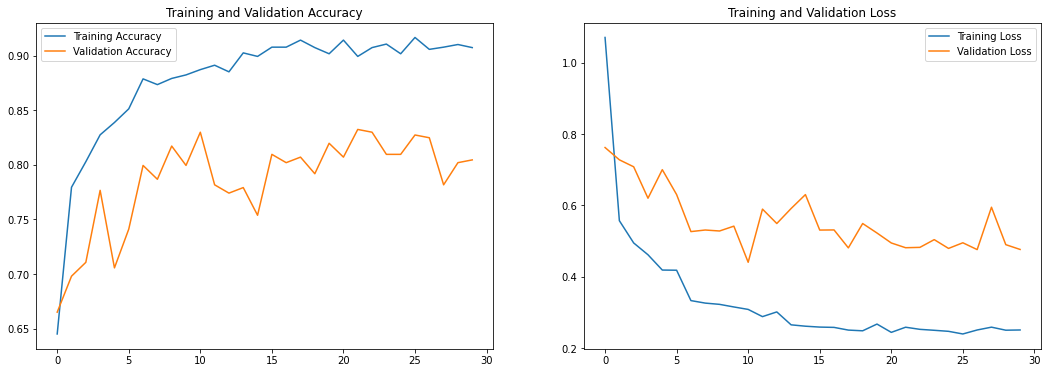

In [45]:
callbacks_DenseNet = [ EarlyStopping(patience = 10, 
                            monitor = "accuracy", 
                            restore_best_weights = True),
                 ReduceLROnPlateau(monitor = 'val_accuracy', 
                                   factor = 0.3, patience = 2, 
                                   min_delta = 0.001, 
                                   mode='auto',verbose=1) ]

history_my_DenseNet = my_DenseNet.fit(training_dataset,
                                epochs = 30,
                                validation_data = validation_dataset,
                                callbacks = callbacks_DenseNet)

plot_graphs(history_my_DenseNet)

13/13 [==============================] - 19s 1s/step


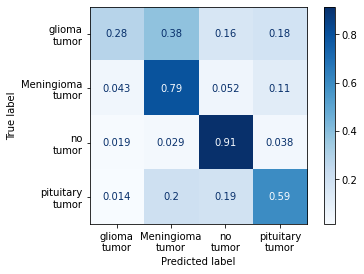

In [49]:
my_DenseNet.evaluate(testing_dataset, verbose=1)
predictions_DenseNet = my_DenseNet.predict(testing_dataset, verbose=1)
pred_DenseNet = np.argmax(predictions_DenseNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_DenseNet, 
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'], 
                                        cmap='Blues', normalize = 'true')

In [59]:
print(classification_report(testing_dataset.labels, pred_DenseNet, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.78      0.28      0.41       100
meningioma tumor       0.62      0.79      0.69       115
        no tumor       0.73      0.91      0.81       105
 pituitary tumor       0.56      0.59      0.58        74

        accuracy                           0.66       394
       macro avg       0.67      0.65      0.62       394
    weighted avg       0.68      0.66      0.63       394



--------
## EfficientNetB0

In [41]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

EfficientNet_input = EfficientNetB0(include_top=False,
                                    weights='imagenet',
                                    pooling = 'avg',
                                    input_shape=(128,128, 3),
                                    classes = 4)
EfficientNet_input.trainable = False

EfficientNet_top = EfficientNet_input.output
EfficientNet_top = Dense(units = 1024, activation = "relu")(EfficientNet_top)
out = Dense(units = 4, activation = "softmax")(EfficientNet_top)

my_EfficientNet = Model(inputs = EfficientNet_input.input, outputs = out)

my_EfficientNet.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

my_EfficientNet.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 128, 128, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 128, 128, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization_1[0][0]            
___________________________________________________________________________________________

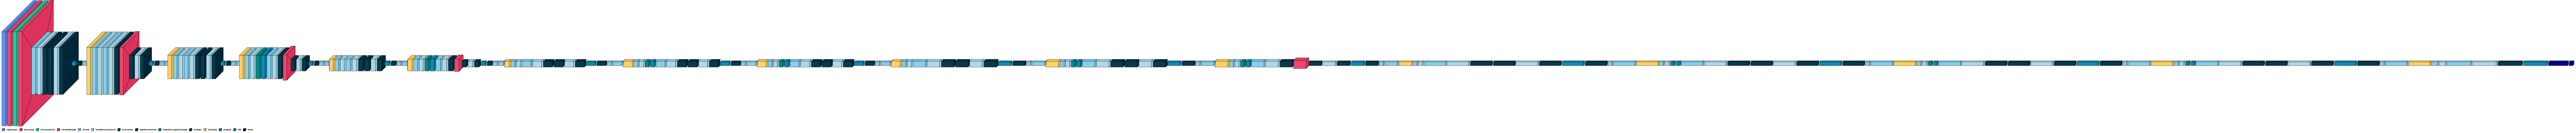

In [54]:
visualkeras.layered_view(my_EfficientNet, legend=True, color_map=color_map)

Epoch 1/30
78/78 [==============================] - 62s 714ms/step - loss: 1.4337 - accuracy: 0.2686 - val_loss: 1.3920 - val_accuracy: 0.2868
Epoch 2/30
78/78 [==============================] - 55s 704ms/step - loss: 1.3615 - accuracy: 0.2835 - val_loss: 1.3674 - val_accuracy: 0.2893
Epoch 3/30
78/78 [==============================] - 55s 706ms/step - loss: 1.3605 - accuracy: 0.2900 - val_loss: 1.3611 - val_accuracy: 0.2868
Epoch 4/30
78/78 [==============================] - 55s 698ms/step - loss: 1.3578 - accuracy: 0.2827 - val_loss: 1.3492 - val_accuracy: 0.2893

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/30
78/78 [==============================] - 55s 709ms/step - loss: 1.3509 - accuracy: 0.2714 - val_loss: 1.3476 - val_accuracy: 0.2893
Epoch 6/30
78/78 [==============================] - 57s 724ms/step - loss: 1.3498 - accuracy: 0.2754 - val_loss: 1.3481 - val_accuracy: 0.2868

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.0

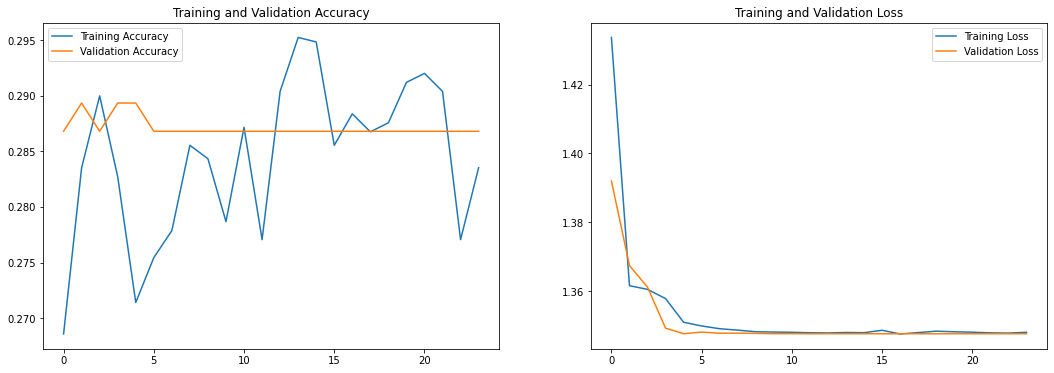

In [46]:
callbacks_EfficientNet = [ EarlyStopping(patience = 10, 
                            monitor = "accuracy", 
                            restore_best_weights = True),
                 ReduceLROnPlateau(monitor = 'val_accuracy', 
                                   factor = 0.3, patience = 2, 
                                   min_delta = 0.001, 
                                   mode='auto',verbose=1) ]

history_my_EfficientNet = my_EfficientNet.fit(training_dataset,
                                epochs = 30,
                                validation_data = validation_dataset,
                                callbacks = callbacks_EfficientNet)

plot_graphs(history_my_EfficientNet)

13/13 [==============================] - 10s 677ms/step


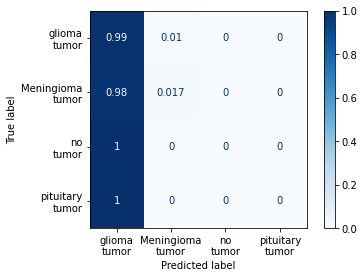

In [50]:
my_EfficientNet.evaluate(testing_dataset, verbose=1)
predictions_EfficientNet = my_EfficientNet.predict(testing_dataset, verbose=1)
pred_EfficientNet = np.argmax(predictions_EfficientNet, axis=1)

ConfusionMatrixDisplay.from_predictions(testing_dataset.classes, pred_EfficientNet, 
                                        display_labels = ['glioma\ntumor', 'Meningioma\ntumor', 'no\ntumor', 'pituitary\ntumor'], 
                                        cmap='Blues', normalize = 'true')

In [60]:
print(classification_report(testing_dataset.labels, pred_EfficientNet, target_names=target_names))

                  precision    recall  f1-score   support

    glioma tumor       0.25      0.99      0.40       100
meningioma tumor       0.67      0.02      0.03       115
        no tumor       0.00      0.00      0.00       105
 pituitary tumor       0.00      0.00      0.00        74

        accuracy                           0.26       394
       macro avg       0.23      0.25      0.11       394
    weighted avg       0.26      0.26      0.11       394



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa